## 0. Install Dependencies

Run this cell once to ensure all required packages are available in the current kernel.

In [1]:
# Install dependencies (run once per kernel)
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
    'boto3', 's3fs', 'pandas', 'numpy', 'matplotlib', 'seaborn',
    'scikit-learn', 'xgboost', 'lightgbm', 'sagemaker', 'pyyaml'])


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


0

# Feature Engineering — Fraud Detection

This notebook demonstrates feature engineering techniques for the fraud detection
dataset using the project's `FeatureEngineer` class and `ExperimentTracker`.

We cover:
1. **Time feature creation** — extract hour, day-of-week, weekend, and night indicators
2. **Amount feature creation** — log, squared, and square-root transformations
3. **Interaction feature creation** — pairwise products of selected features
4. **Feature selection** — univariate (SelectKBest) and RFE methods
5. **Feature importance analysis** — Random Forest importance ranking
6. **Impact analysis** — compare model performance with selected vs all features

All experiments are logged to the `ExperimentTracker` for reproducibility.

**Requirements covered:** 5.1 (derived features), 5.2 (feature selection), 5.3 (experiment logging), 5.4 (feature impact analysis)

## 1. Setup and Imports

In [2]:
import sys
import io

import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Add project src to path
sys.path.insert(0, '../src')
from feature_engineering import FeatureEngineer
from experiment_tracking import ExperimentTracker

sns.set_theme(style='whitegrid')
%matplotlib inline

## 2. Load Data from S3

Load the processed fraud detection dataset from the `fraud-detection-data-<suffix>` bucket.
The dataset contains columns `Time`, `Amount`, `V1`–`V28`, and `Class` (0 = legitimate, 1 = fraud).

In [3]:
import os
BUCKET_SUFFIX = os.environ.get('BUCKET_SUFFIX', 'quannh0308-20260222')
BUCKET_NAME = f'fraud-detection-data-{BUCKET_SUFFIX}'
DATA_PREFIX = 'prepared'

# Read partitioned Parquet directories directly from S3
train_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/train.parquet/')
test_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/test.parquet/')

print(f'Training set:  {train_df.shape[0]:,} rows, {train_df.shape[1]} columns')
print(f'Test set:      {test_df.shape[0]:,} rows, {test_df.shape[1]} columns')
train_df.head()

Training set:  199,824 rows, 31 columns
Test set:      42,337 rows, 31 columns


,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
3,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
4,0,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67


## 3. Time Feature Creation

The `Time` column represents seconds since the first transaction in the dataset.
`create_time_features` converts it to human-readable temporal signals:
- `hour` — hour of the day (0–23)
- `day_of_week` — day of the week (0 = Monday, 6 = Sunday)
- `is_weekend` — 1 if Saturday or Sunday, 0 otherwise
- `is_night` — 1 if hour is between 22:00 and 06:00

**Requirement 5.1**: Provide utilities for creating derived features (time-based)

In [4]:
engineer = FeatureEngineer()

# Create time features on training data
train_df = engineer.create_time_features(train_df)
test_df = engineer.create_time_features(test_df)

time_features = ['hour', 'day_of_week', 'is_weekend', 'is_night']
print('New time features:')
train_df[time_features].describe()

New time features:


,hour,day_of_week,is_weekend,is_night
count,199824.000000,199824.000000,199824.0,199824.0
mean,14.045120,3.491122,0.0,0.0
std,5.838738,0.499922,0.0,0.0
min,0.000000,3.000000,0.0,0.0
25%,10.000000,3.000000,0.0,0.0
50%,15.000000,3.000000,0.0,0.0
75%,19.000000,4.000000,0.0,0.0
max,23.000000,4.000000,0.0,0.0


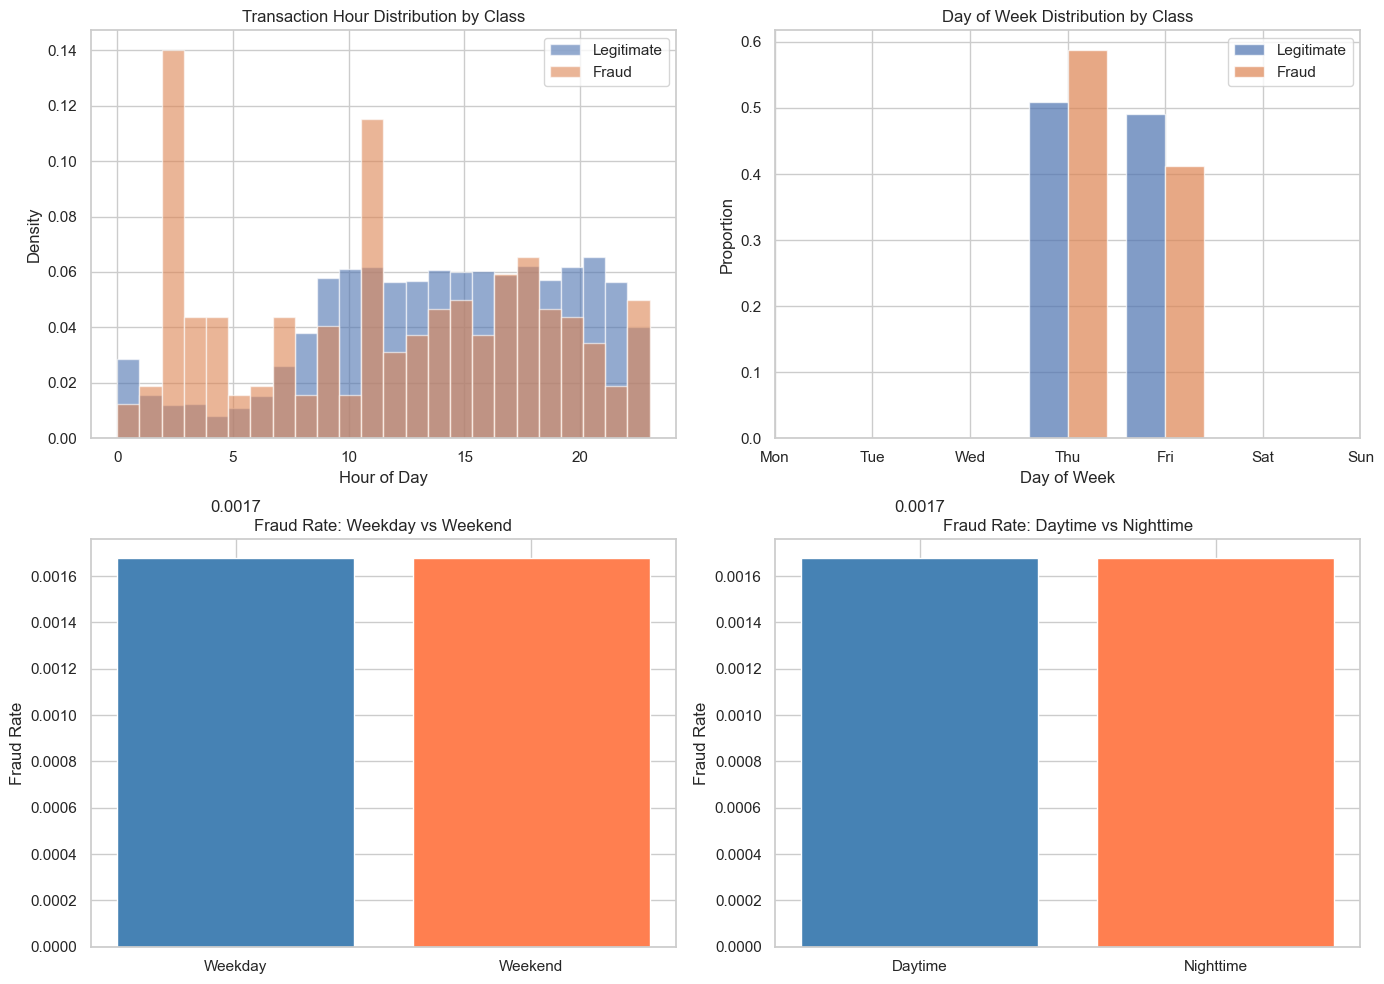

In [5]:
# Visualize time feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hour distribution by class
ax = axes[0, 0]
for label, group in train_df.groupby('Class'):
    ax.hist(group['hour'], bins=24, alpha=0.6,
            label='Legitimate' if label == 0 else 'Fraud', density=True)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Density')
ax.set_title('Transaction Hour Distribution by Class')
ax.legend()

# Day of week distribution by class
ax = axes[0, 1]
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for label, group in train_df.groupby('Class'):
    counts = group['day_of_week'].value_counts().sort_index()
    ax.bar(counts.index + (-0.2 if label == 0 else 0.2), counts.values / counts.sum(),
           width=0.4, alpha=0.7, label='Legitimate' if label == 0 else 'Fraud')
ax.set_xticks(range(7))
ax.set_xticklabels(day_labels)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Proportion')
ax.set_title('Day of Week Distribution by Class')
ax.legend()

# Weekend vs weekday fraud rate
ax = axes[1, 0]
weekend_fraud = train_df.groupby('is_weekend')['Class'].mean()
bars = ax.bar(['Weekday', 'Weekend'], weekend_fraud.values, color=['steelblue', 'coral'])
for bar, val in zip(bars, weekend_fraud.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0002,
            f'{val:.4f}', ha='center')
ax.set_ylabel('Fraud Rate')
ax.set_title('Fraud Rate: Weekday vs Weekend')

# Night vs day fraud rate
ax = axes[1, 1]
night_fraud = train_df.groupby('is_night')['Class'].mean()
bars = ax.bar(['Daytime', 'Nighttime'], night_fraud.values, color=['steelblue', 'coral'])
for bar, val in zip(bars, night_fraud.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0002,
            f'{val:.4f}', ha='center')
ax.set_ylabel('Fraud Rate')
ax.set_title('Fraud Rate: Daytime vs Nighttime')

plt.tight_layout()
plt.savefig('time_features.png', dpi=150)
plt.show()

## 4. Amount Feature Creation

`create_amount_features` derives three transformations of the `Amount` column:
- `amount_log` — log(1 + Amount), reduces skewness
- `amount_squared` — Amount², amplifies large-value differences
- `amount_sqrt` — √Amount, compresses large values

**Requirement 5.1**: Provide utilities for creating derived features (aggregations)

In [6]:
train_df = engineer.create_amount_features(train_df)
test_df = engineer.create_amount_features(test_df)

amount_features = ['Amount', 'amount_log', 'amount_squared', 'amount_sqrt']
print('Amount feature statistics:')
train_df[amount_features].describe()

Amount feature statistics:


,Amount,amount_log,amount_squared,amount_sqrt
count,199824.000000,199824.000000,1.998240e+05,199824.000000
mean,88.509115,3.149472,7.221308e+04,6.679773
std,253.731238,1.658176,1.983483e+06,6.624950
min,0.000000,0.000000,0.000000e+00,0.000000
25%,5.490000,1.870263,3.014010e+01,2.343075
50%,21.950000,3.133318,4.818025e+02,4.685083
75%,77.000000,4.356709,5.929000e+03,8.774964
max,25691.160000,10.153941,6.600357e+08,160.284622


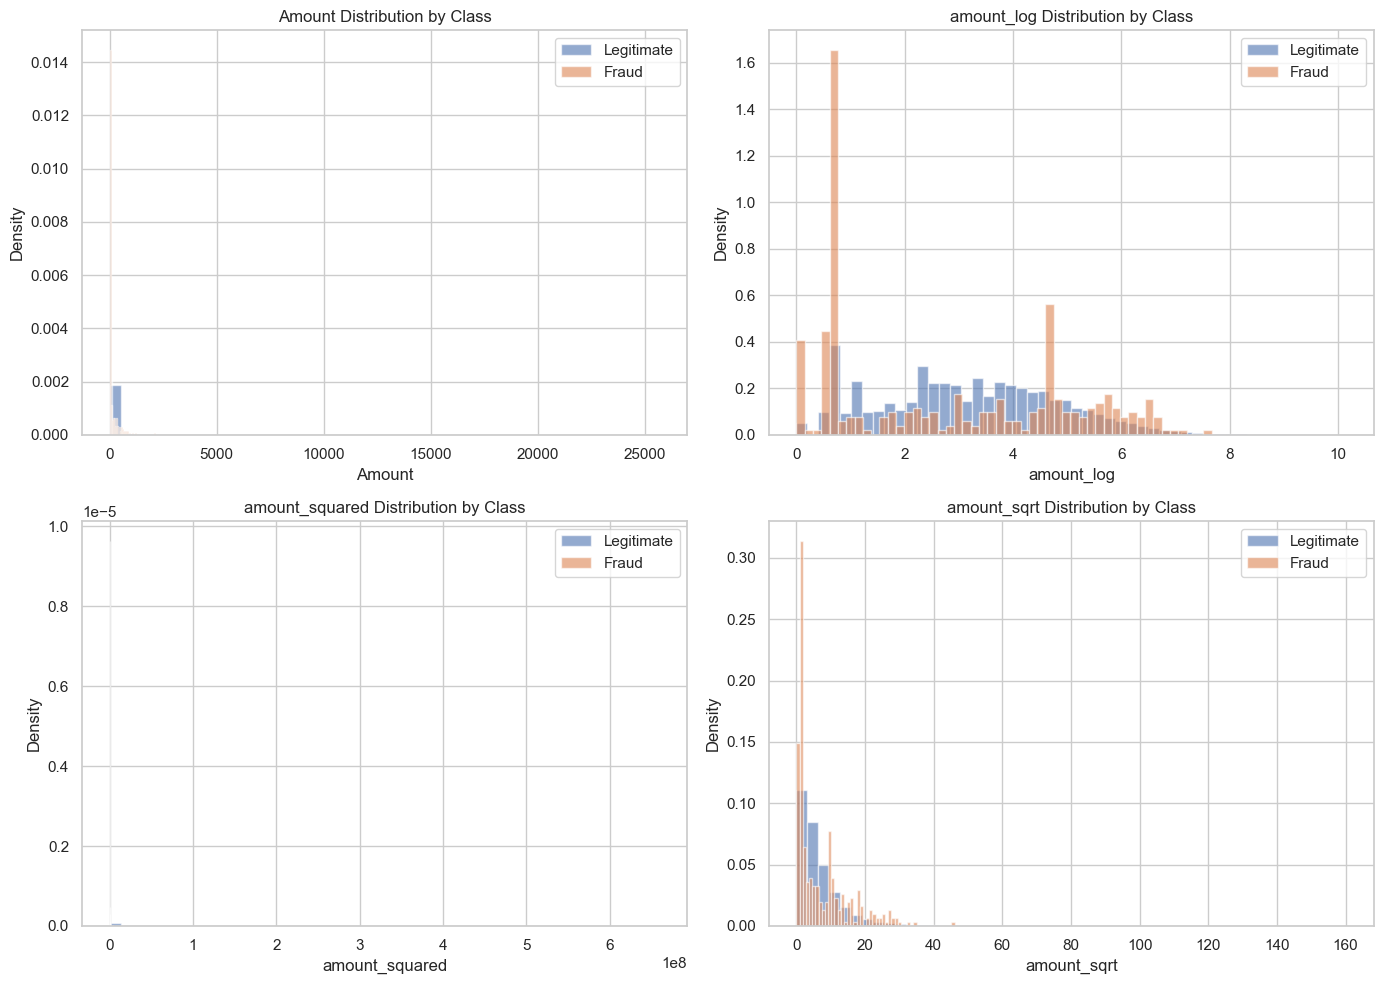

In [7]:
# Visualize amount feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, feat in enumerate(amount_features):
    ax = axes[idx // 2, idx % 2]
    for label, group in train_df.groupby('Class'):
        ax.hist(group[feat], bins=50, alpha=0.6, density=True,
                label='Legitimate' if label == 0 else 'Fraud')
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')
    ax.set_title(f'{feat} Distribution by Class')
    ax.legend()

plt.tight_layout()
plt.savefig('amount_features.png', dpi=150)
plt.show()

## 5. Interaction Feature Creation

`create_interaction_features` computes element-wise products for specified
feature pairs. This captures non-linear relationships between features.

**Requirement 5.1**: Provide utilities for creating derived features (interactions)

In [8]:
interaction_pairs = [('V1', 'V2'), ('V3', 'V4'), ('V1', 'Amount')]

train_df = engineer.create_interaction_features(train_df, interaction_pairs)
test_df = engineer.create_interaction_features(test_df, interaction_pairs)

interaction_cols = [f'{a}_x_{b}' for a, b in interaction_pairs]
print('Interaction features created:', interaction_cols)
train_df[interaction_cols].describe()

Interaction features created: ['V1_x_V2', 'V3_x_V4', 'V1_x_Amount']


,V1_x_V2,V3_x_V4,V1_x_Amount
count,199824.000000,199824.000000,199824.000000
mean,0.023657,-0.001187,-115.626830
std,22.701177,4.908961,3369.097454
min,-633.260398,-739.583711,-913283.208643
25%,-1.056201,-0.530197,-16.607895
50%,-0.358229,0.010546,0.011573
75%,0.081153,0.688912,33.728345
max,4101.713103,24.374173,2459.298594


## 6. Feature Selection — Univariate (SelectKBest)

`select_features_univariate` uses the ANOVA F-value (`f_classif`) to rank
features by their individual predictive power and selects the top *k*.

**Requirement 5.2**: Provide feature selection methods (feature importance, correlation analysis)

In [9]:
# Prepare feature matrix (exclude target and raw Time)
TARGET = 'Class'
EXCLUDE = [TARGET, 'Time']
ALL_FEATURES = [c for c in train_df.columns if c not in EXCLUDE]

X_train = train_df[ALL_FEATURES]
y_train = train_df[TARGET]
X_test = test_df[ALL_FEATURES]
y_test = test_df[TARGET]

print(f'Total features available: {len(ALL_FEATURES)}')

Total features available: 39


In [10]:
K = 20
selected_univariate, scores_df = engineer.select_features_univariate(X_train, y_train, k=K)

print(f'Top {K} features (univariate):')
print(selected_univariate)
scores_df.head(K)

Top 20 features (univariate):
['V3_x_V4', 'V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1', 'V9', 'V5', 'V2', 'V1_x_V2', 'V6', 'V21', 'V19', 'V20']


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [31 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,feature,score
37,V3_x_V4,35455.657580
16,V17,24486.598795
13,V14,20098.250610
11,V12,14861.732399
9,V10,9957.312685
15,V16,8271.359984
2,V3,7412.929684
6,V7,7338.016358
10,V11,4950.411607
3,V4,3549.342700


/var/folders/31/vzjxj1qx6lg6wz36yn5dwwjm0000gr/T/ipykernel_13161/1906329205.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_scores, x='score', y='feature', palette='viridis')


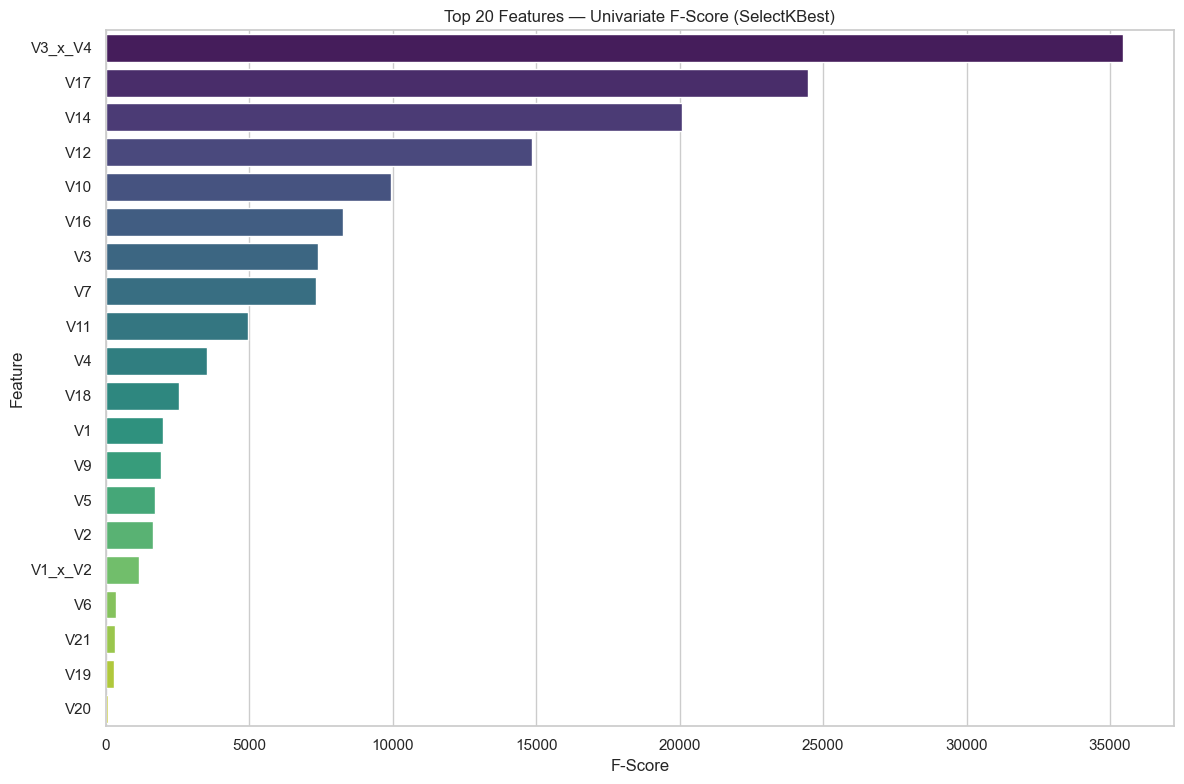

In [11]:
# Visualize univariate feature scores
top_scores = scores_df.head(K)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_scores, x='score', y='feature', palette='viridis')
plt.title(f'Top {K} Features — Univariate F-Score (SelectKBest)')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('univariate_feature_scores.png', dpi=150)
plt.show()

## 7. Feature Selection — Recursive Feature Elimination (RFE)

`select_features_rfe` uses a Random Forest estimator to iteratively remove the
least important features until the desired count is reached. Features with
ranking = 1 are selected.

**Requirement 5.2**: Provide feature selection methods (recursive elimination)

In [12]:
N_FEATURES_RFE = 20
selected_rfe, ranking_df = engineer.select_features_rfe(X_train, y_train, n_features=N_FEATURES_RFE)

print(f'Top {N_FEATURES_RFE} features (RFE):')
print(selected_rfe)
ranking_df.head(N_FEATURES_RFE)

Top 20 features (RFE):
['V1', 'V3', 'V4', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V20', 'V21', 'V24', 'V26', 'V27', 'amount_squared', 'V3_x_V4']


,feature,ranking
0,V1,1
34,amount_squared,1
26,V27,1
25,V26,1
23,V24,1
20,V21,1
37,V3_x_V4,1
16,V17,1
15,V16,1
13,V14,1


/var/folders/31/vzjxj1qx6lg6wz36yn5dwwjm0000gr/T/ipykernel_13161/377052359.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_ranking, x='ranking', y='feature', palette=colors)


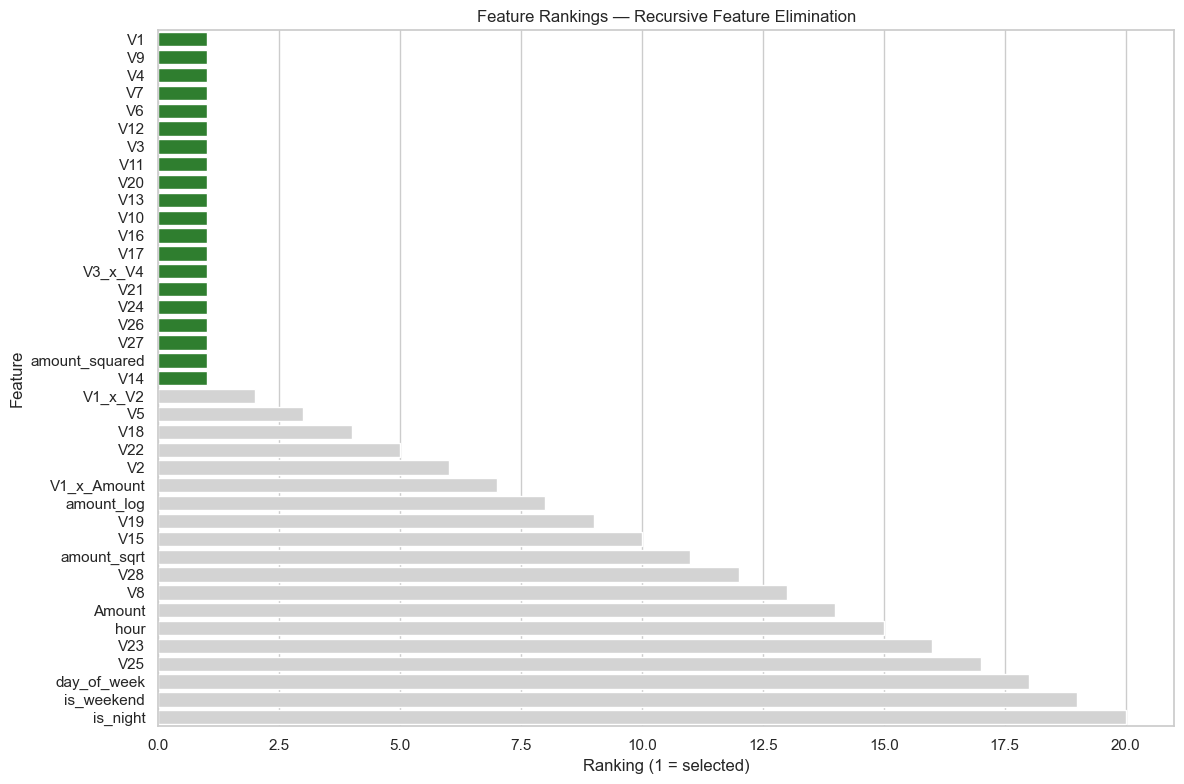

In [13]:
# Visualize RFE rankings
plt.figure(figsize=(12, 8))
sorted_ranking = ranking_df.sort_values('ranking')
colors = ['forestgreen' if r == 1 else 'lightgray' for r in sorted_ranking['ranking']]
sns.barplot(data=sorted_ranking, x='ranking', y='feature', palette=colors)
plt.title('Feature Rankings — Recursive Feature Elimination')
plt.xlabel('Ranking (1 = selected)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('rfe_feature_rankings.png', dpi=150)
plt.show()

## 8. Feature Importance Analysis

`analyze_feature_importance` trains a Random Forest on the full feature set and
returns Gini importance scores. This gives a holistic view of which features
contribute most to the model's decisions.

**Requirement 5.2**: Provide feature selection methods (feature importance)

In [14]:
importance_df = engineer.analyze_feature_importance(X_train, y_train)

print('Top 20 features by Random Forest importance:')
importance_df.head(20)

Top 20 features by Random Forest importance:


,feature,importance
11,V12,0.167799
16,V17,0.140699
13,V14,0.108114
10,V11,0.086536
9,V10,0.064235
15,V16,0.057499
17,V18,0.028840
8,V9,0.028064
3,V4,0.022806
6,V7,0.020874


/var/folders/31/vzjxj1qx6lg6wz36yn5dwwjm0000gr/T/ipykernel_13161/170719643.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_importance, x='importance', y='feature', palette='magma')


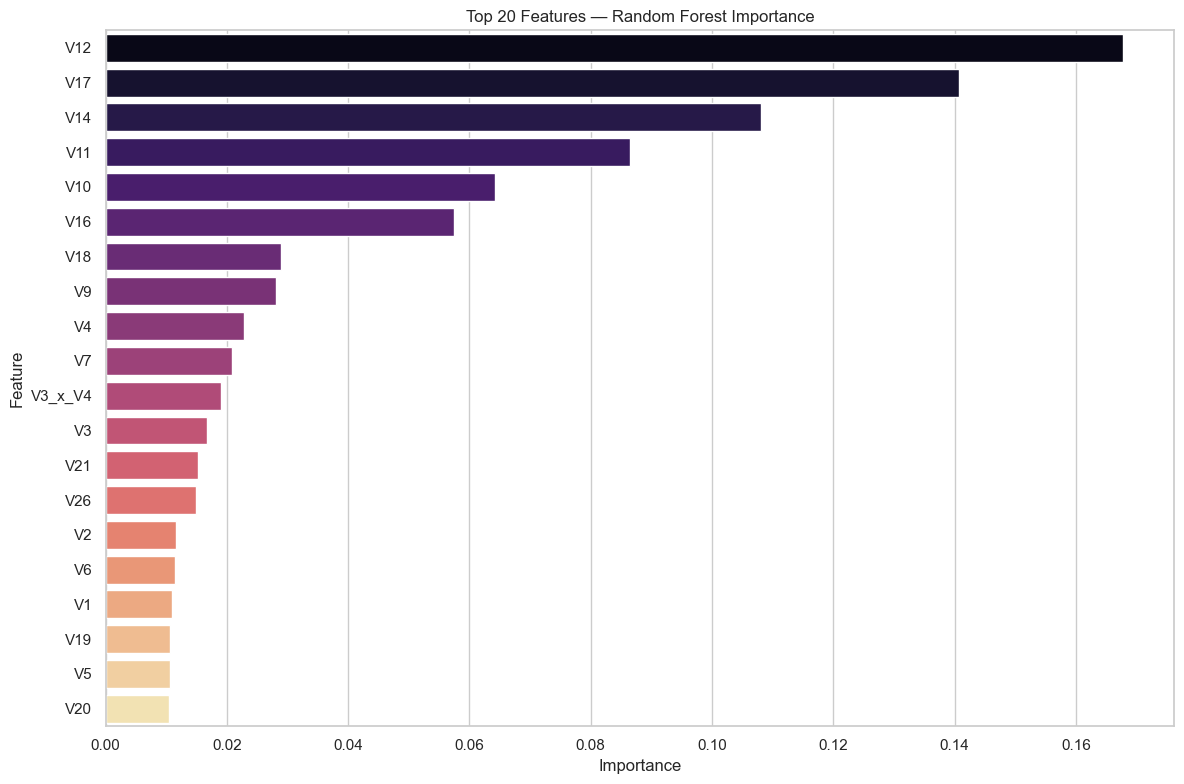

In [15]:
# Bar chart of feature importance
top_importance = importance_df.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_importance, x='importance', y='feature', palette='magma')
plt.title('Top 20 Features — Random Forest Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

## 9. Feature Impact Analysis — Selected vs All Features

To quantify the impact of feature selection, we train an XGBoost model twice:
1. Using **all** available features
2. Using only the **selected** features from univariate selection

This shows whether feature selection improves or maintains performance while
reducing dimensionality.

**Requirement 5.4**: Provide feature impact analysis showing performance changes from feature additions or removals

In [16]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    """Train a model and return classification metrics."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]
    return {
        'accuracy': accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred),
        'recall': recall_score(y_te, y_pred),
        'f1': f1_score(y_te, y_pred),
        'auc_roc': roc_auc_score(y_te, y_proba),
    }


# Model with ALL features
model_all = XGBClassifier(
    max_depth=5, learning_rate=0.2, n_estimators=100,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss',
)
metrics_all = evaluate_model(model_all, X_train, y_train, X_test, y_test)

# Model with SELECTED features (univariate top-K)
model_selected = XGBClassifier(
    max_depth=5, learning_rate=0.2, n_estimators=100,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss',
)
metrics_selected = evaluate_model(
    model_selected,
    X_train[selected_univariate], y_train,
    X_test[selected_univariate], y_test,
)

print(f'All features ({len(ALL_FEATURES)}):      {metrics_all}')
print(f'Selected features ({K}): {metrics_selected}')

/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:34:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:34:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


All features (39):      {'accuracy': 0.9994567399674044, 'precision': 0.9565217391304348, 'recall': 0.7674418604651163, 'f1': 0.8516129032258064, 'auc_roc': 0.9721300115092915}
Selected features (20): {'accuracy': 0.9994331199659872, 'precision': 0.9558823529411765, 'recall': 0.7558139534883721, 'f1': 0.8441558441558441, 'auc_roc': 0.975848927203044}


In [17]:
# Compare metrics side by side
comparison = pd.DataFrame({
    'Metric': list(metrics_all.keys()),
    f'All Features ({len(ALL_FEATURES)})': list(metrics_all.values()),
    f'Selected Features ({K})': list(metrics_selected.values()),
})
comparison['Difference'] = comparison[f'Selected Features ({K})'] - comparison[f'All Features ({len(ALL_FEATURES)})']
comparison

,Metric,All Features (39),Selected Features (20),Difference
0,accuracy,0.999457,0.999433,-0.000024
1,precision,0.956522,0.955882,-0.000639
2,recall,0.767442,0.755814,-0.011628
3,f1,0.851613,0.844156,-0.007457
4,auc_roc,0.972130,0.975849,0.003719


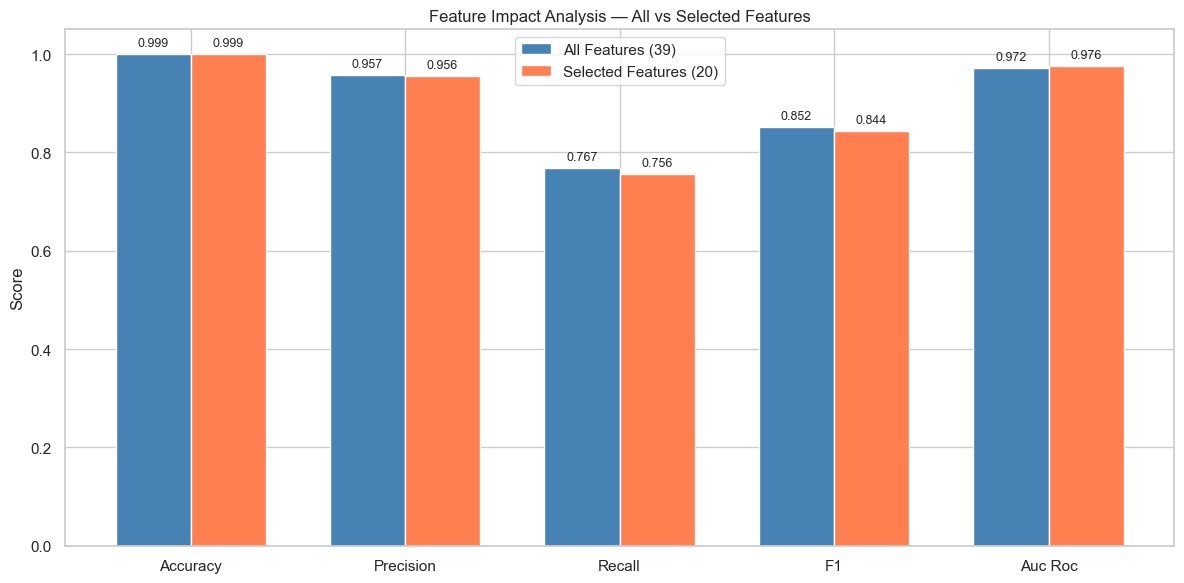

In [18]:
# Grouped bar chart: all features vs selected features
metric_names = list(metrics_all.keys())
x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width / 2, list(metrics_all.values()), width,
               label=f'All Features ({len(ALL_FEATURES)})', color='steelblue')
bars2 = ax.bar(x + width / 2, list(metrics_selected.values()), width,
               label=f'Selected Features ({K})', color='coral')

ax.set_ylabel('Score')
ax.set_title('Feature Impact Analysis — All vs Selected Features')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metric_names])
ax.set_ylim(0, 1.05)
ax.legend()

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('feature_impact_analysis.png', dpi=150)
plt.show()

## 10. Log Feature Engineering Experiment

Log the feature engineering experiment to the `ExperimentTracker` so that the
feature set, selection method, and resulting metrics are recorded for
reproducibility.

**Requirement 5.3**: Log the feature set used and resulting model performance

In [19]:
tracker = ExperimentTracker(region_name='us-east-1')

# Log experiment with all features
exp_all = tracker.start_experiment(
    experiment_name='feature-engineering',
    algorithm='XGBoost',
)
tracker.log_parameters(exp_all, {
    'n_features': len(ALL_FEATURES),
    'selection_method': 'none',
    'feature_set': 'all',
    'max_depth': 5,
    'learning_rate': 0.2,
    'n_estimators': 100,
})
tracker.log_metrics(exp_all, metrics_all)
tracker.close_experiment(exp_all)
print(f'Logged all-features experiment: {exp_all}')

# Log experiment with selected features
exp_selected = tracker.start_experiment(
    experiment_name='feature-engineering',
    algorithm='XGBoost',
)
tracker.log_parameters(exp_selected, {
    'n_features': K,
    'selection_method': 'univariate_f_classif',
    'feature_set': ', '.join(selected_univariate),
    'max_depth': 5,
    'learning_rate': 0.2,
    'n_estimators': 100,
})
tracker.log_metrics(exp_selected, metrics_selected)
tracker.close_experiment(exp_selected)
print(f'Logged selected-features experiment: {exp_selected}')

Logged all-features experiment: XGBoost-20260222-233426-6e779f5c
Logged selected-features experiment: XGBoost-20260222-233426-2d676dbf


## 11. Summary

### What we covered

| Step | Technique | New Features / Output |
|------|-----------|----------------------|
| Time features | `create_time_features` | `hour`, `day_of_week`, `is_weekend`, `is_night` |
| Amount features | `create_amount_features` | `amount_log`, `amount_squared`, `amount_sqrt` |
| Interaction features | `create_interaction_features` | `V1_x_V2`, `V3_x_V4`, `V1_x_Amount` |
| Univariate selection | `select_features_univariate` | Top-K features by F-score |
| RFE selection | `select_features_rfe` | Top-N features by recursive elimination |
| Importance analysis | `analyze_feature_importance` | Random Forest Gini importance ranking |
| Impact analysis | XGBoost comparison | All features vs selected features |

### Key takeaways

- Feature selection can maintain (or improve) model performance while reducing
  dimensionality, leading to faster training and simpler models.
- Different selection methods may agree on the most important features but
  diverge on borderline ones — combining methods gives a more robust picture.
- All experiments are logged to the ExperimentTracker for full reproducibility.

### Next steps

1. **Tune hyperparameters** on the selected feature set using
   `02_hyperparameter_tuning.ipynb`.
2. **Compare algorithms** with the engineered features using
   `03_algorithm_comparison.ipynb`.
3. **Promote to production** via `05_production_promotion.ipynb` once the best
   configuration is identified.

## Save Best Results

Save the best feature set to `experiment_results.json` for use in notebook 05 (production promotion).

In [20]:
import json
from datetime import datetime
from pathlib import Path

results_path = Path('../experiment_results.json')

# Load existing results
if results_path.exists():
    with open(results_path) as f:
        all_results = json.load(f)
else:
    all_results = {}

# Save the univariate selected features (best performing selection method)
all_results['feature_engineering'] = {
    'selected_features': selected_univariate,
    'selection_method': 'univariate_f_classif',
    'n_features': len(selected_univariate),
    'accuracy_all_features': float(metrics_all.get('accuracy', 0)),
    'accuracy_selected_features': float(metrics_selected.get('accuracy', 0)),
    'timestamp': datetime.now().isoformat(),
}

with open(results_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print(f'Saved feature engineering results to {results_path}')
print(f'Selected {len(selected_univariate)} features via univariate selection')

Saved feature engineering results to ../experiment_results.json
Selected 20 features via univariate selection
